# 프로젝트: 인물 모드 문제점 찾기

목표 :  
인물모드에서 쉘로우 포커스, 크로마키 적용해 보기  
결과물에서 문제점을 인식하고 해결방법을 제시하기

## Step 1. 인물모드 직접 해 보기  

최소 3장 이상의 인물모드 사진으로 쉘로우 포커스, 크로마키 적용해보기.

## 1-1. 내 사진으로 해보기

### 이미지 불러오기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib #urllib 패키지는 웹에서 데이터를 다운로드 받을 때 사용

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

from PIL import Image

In [2]:
import os
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'
img_path = img_dir + '/my_image.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2576, 1932, 3)


### DeepLabModel 클래스  
구글에서 제공하는 모델 구조

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 모델 다운 받아 로드 

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac6/aiffel/human_segmentation/models
model loaded successfully!


### 모델로 세그멘테이션 예측

In [57]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(2576, 1932, 3) (513, 384, 3) 15


라벨확인

In [9]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
# label 중 person은 index가 15
LABEL_NAMES.index('person')

15

이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다.   
사람은 15인덱스값을 가지므로 사람이라 인식한 fixel에 15값으로 mapping 되었다. 

In [10]:
seg_map[300] 

array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 15, 15

### 예측 중 사람만 추출하여 normalization 한 이미지

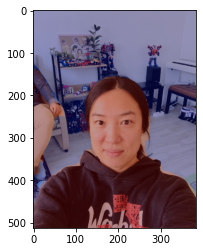

In [58]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 사람인 부분을 255 흰색으로 구분하고, 실제 크기와 비교

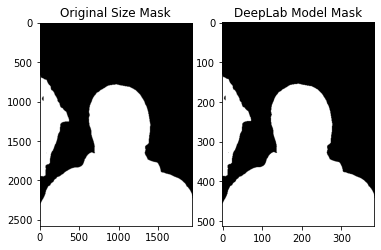

In [59]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) #128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 배경 흐리게 하기

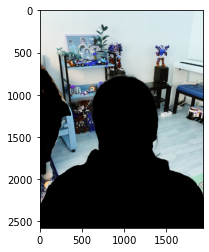

In [60]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) 
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) 
plt.imshow(img_bg)
plt.show()

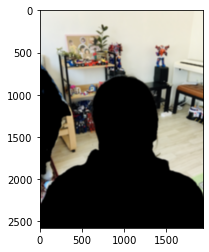

In [61]:
# 이 이미지를 블러(blur)하면 배경이 흐리게 처리된 영상을 얻을 수 있다. 
img_bg_blur = cv2.blur(img_bg, (20,20))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 영상 합성

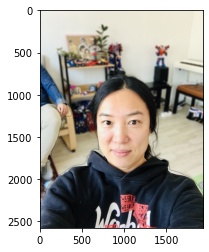

In [62]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) #img_mask_color는 사람이미지를 255로 바꿔놓은 거 
blur_my_image = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
blur_image_path = img_dir + '/blur_my_image.jpg'
Image.fromarray(blur_my_image).save(blur_image_path) # 이미지 저장

plt.imshow(blur_my_image)
plt.show()

## 1-2. 다른 이미지도 해보기 

### 위 과정을 함수화 ###

In [31]:
def shallow_focus(model, v_image_orig, seg, v_img_back, s):

    # Model Run
    img_resized, seg_map = model.run(v_image_orig)  
    
    fig = plt.figure(figsize=(15, 10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    
    # 1. Normalization Color Mask
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == seg, seg, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)    

    ax1 = plt.subplot(spec[0, 0])
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    ax1.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    ax1.set_title("Normalization Color Mask")
    
    # 2. Original Size Mask
    img_mask_up = cv2.resize(img_mask, v_image_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) #128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법

    ax2 = plt.subplot(spec[0, 1])
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax2.set_title('Original Size Mask')
    
    ax3 = plt.subplot(spec[0, 2])
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax3.set_title('DeepLab Model Mask')
       
    # 3. Background Image Blur
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) 
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg = cv2.bitwise_and(v_image_orig, img_bg_mask)     
    img_bg_blur = cv2.blur(img_bg, (15,15))
    
    ax4 = plt.subplot(spec[1, 0])
    ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    ax4.set_title('Background Image Blur')    
    
    # 4. Concat Background Image Blur
    img_concat = np.where(img_mask_color==255, v_image_orig, img_bg_blur)
    
    ax5 = plt.subplot(spec[1, 1])
    img_concat_rgb = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
    blur_concat_image_path = img_dir + '/blur_{}_image.jpg'.format(s)
    Image.fromarray(img_concat_rgb).save(blur_concat_image_path) # 이미지 저장
    ax5.imshow(img_concat_rgb)
    ax5.set_title('Concat Background Image Blur')
    
    # 5. Concat Background Image Blur    
    img_back_concat = np.where(img_mask_color==255, v_image_orig, v_img_back)
    
    ax6 = plt.subplot(spec[1, 2])
    img_back_concat_rgb = cv2.cvtColor(img_back_concat, cv2.COLOR_BGR2RGB)
    back_concat_image_path = img_dir + '/back_concat_{}_image.jpg'.format(s)
    Image.fromarray(img_back_concat_rgb).save(back_concat_image_path) # 이미지 저장
    ax6.imshow(img_back_concat_rgb)
    ax6.set_title('Concat Background Image Blur')
    
    plt.show()


### 1-2-1. 엘사 인형으로 셸로우 포커스 만들기

In [28]:
import os
img_path = img_dir + '/elsa_image.jpg' 
img_elsa_orig = cv2.imread(img_path) 
print (img_elsa_orig.shape)

img_path = img_dir + '/hong_image.JPG'
hong_image = cv2.imread(img_path) 
print (hong_image.shape)

(4032, 3024, 3)
(4032, 3024, 3)


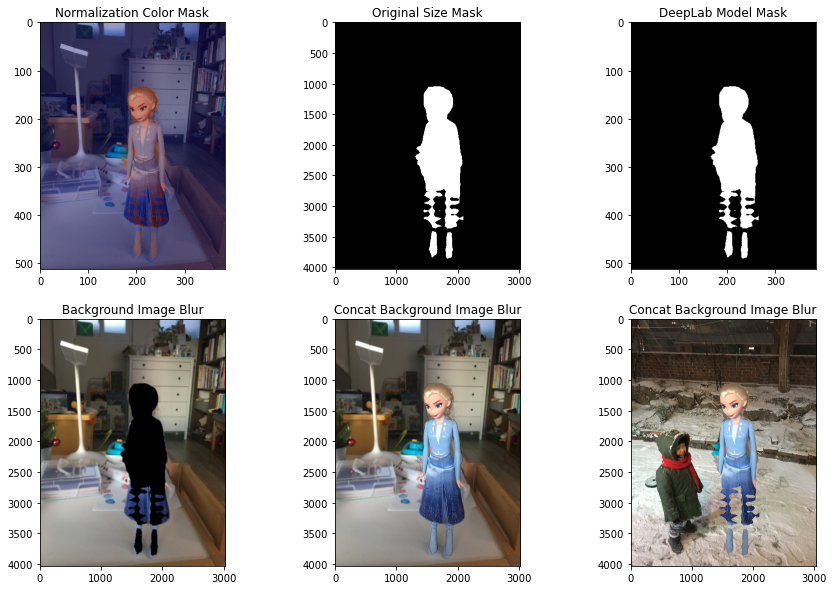

In [29]:
shallow_focus(MODEL, img_elsa_orig, 15, hong_image, 'elsa')

### 1-2-2.  사람으로 셸로우 포커스 만들기

In [32]:
import os
img_path = img_dir + '/hong_image2.JPG' 
hong_image2 = cv2.imread(img_path) 
hong_image2  = cv2.resize(hong_image2, (640,480)) # 640x360의 크기로 Resize
print (hong_image2.shape)

img_path = img_dir + '/summer_back_image.jpg'
summer_back_image = cv2.imread(img_path) 
summer_back_image = cv2.resize(summer_back_image, (640,480)) # 640x360의 크기로 Resize
print (summer_back_image.shape)

(480, 640, 3)
(480, 640, 3)


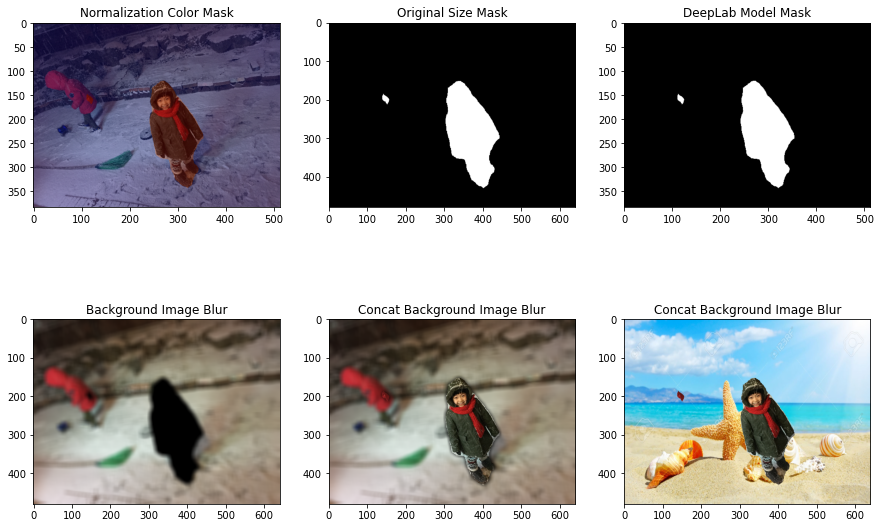

In [33]:
shallow_focus(MODEL, hong_image2,  15, summer_back_image,'hong')

## Step 2. 사진에서 문제점 찾기 


<img src="./images/blur_my_image_text.jpg" width="30%" height="30%" align="left"></img><img src="./images/back_concat_text.jpg" width="30%" height="30%" ></img><img src="./images/hong_concat_text.jpg" width="30%" height="30%" align="left" ></img>

문제점 :  
1. 포커스하려는 사람과 배경에 있는 사람을 구분하지 못 한다. 얼굴 없이 팔이나 다리 일부가 나왔다면 포커스하는 부분에서 빼야할거 같다.  
2. 포커스하려는 사람 주위에 경계선이 생긴다. 
3. 포커스하려는 사람과 배경의 경계가 불분명해지는 부분이 생긴다.

## Step 3. 해결 방법을 제안해 보기  

2D 이미지를 사용해 segmentation을 했다. 이미지를 3D 와 같이 재구성 해낼 수 있다면 인식할 대상과 그 외 대상을 분리해낼 수 있겠다. RGB뿐만 아니라 depth도 측정하고 계산 된다면 뒷 배경에 있는 사람 또는 경계가 불분명한 부분이 해결 될 수 있을 거 같다.   

Stereo Depth Sensing이 그 역할을 담당할 수 있는거 같다. 한쪽눈을 번갈아 감는 것을 반복했을 때, 보이는 위치가 바뀌는데 이걸 이용하여 Depth를 계산해낸다. 하지만 이런 센스 장비를 사용하지 않고 알고리즘으로 해결한 것이 단일 영상 거리 측정기술인 Monodepth2이다.   

단일 영상에서의 거리측정 기술은 기존의 고전적인 접근 방법으로는 한계가 있었던 분야였으나 딥러닝으로 RGB 영상뿐만 아니라 카메라 포즈,optical flow, surface normal, segmentation 등 주변 정보를 함께 학습함으로써 양안 영상으로 얻은 수준의 성능에 접근하는 등 괄목할 만한 성능의 성장을 이루어 졌다고 한다. 

Monodepth2 는 깊이를 측정하기 위해 한 프레임에서 다음 프레임으로의 픽셀 차이를 사용하는 비지도 딥 러닝 접근 방식이다. 

Monodepth2 방식은 단일 프레임에서 깊이를 예측하기 위해 depth 및 pose 네트워크의 조합을 사용하는 방법이다. 두 네트워크를 훈련하기 위해 일련의 프레임과 몇 가지 손실함수에 대한 아키텍처를 훈련하여 이를 수행한다. 이 방법은 훈련을 위한 ground truth dataset을 필요로 하지 않는다. 이미지 시퀀스에서 연속적인 시간 프레임을 사용하여 훈련 신호를 제공한다. 학습을 제한하기 위해 pose estimation 네트워크를 사용한다. 모델은 pose 네트워크와 depth 네트워크의 출력에서 재구성된 이미지와 입력 이미지의 차이에 대해 학습한다. 

depth 네트워크는 고전적인 U-Net 인코더-디코더 아키텍처이다. 인코더는 사전 훈련 된 ResNet 모델입니다. depth 디코더는 시그모이드 출력을 depth 값으로 변환한다.단일 6-DoF relative 포즈 또는 회전 및 변환을 예측하기 위해 두 개의 컬러 이미지를 입력으로 취하도록 수정 된 ResNet18의 포즈 네트워크를 사용한다. 포즈 네트워크는 일반적인 스테레오 쌍이 아닌 시간 프레임을 이미지 쌍으로 사용한다. 시퀀스의 다른 이미지 관점에서 대상 이미지의 모양을 예측한다. 아래는 훈련과정을 나타낸 것이다. 

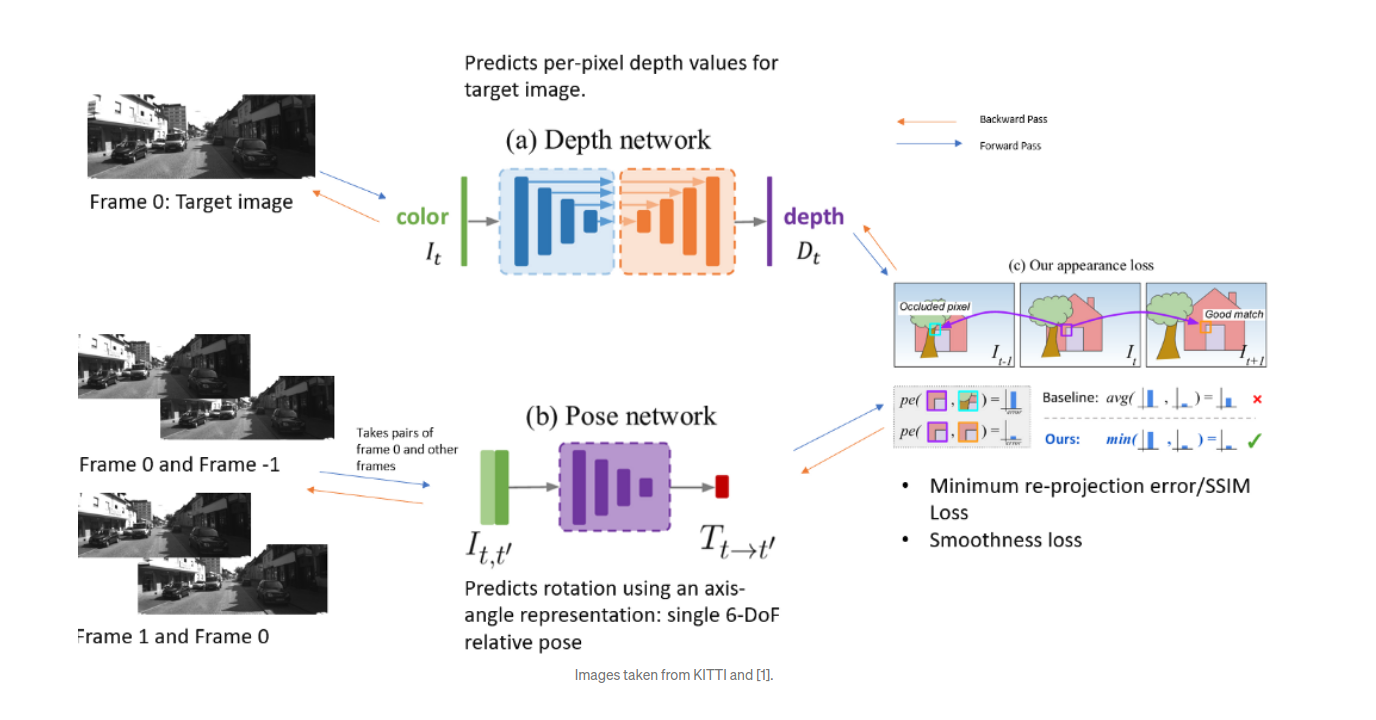  


## 느낀점
3D로 표현할 수 있는 영상 장비를 넘어서 딥러닝만으로 이미지의 depth를 표현할 수 있다는 것이 놀라웠다.  
해당 논문과 글을 다 이해할 수는 없었는데, 좀 더 공부하여 구현까지 해보면 좋겠다는 생각을 했다.  
이번 노드에서 이미지를 세그멘테이션하고 배경을 결합하는 작업이 재미있었다.   
하지만 결과물의 문제점에 대해 해결책을 찾는 과정이 어려워 시간을 허비한것이 아쉽다. 